### A Crash Course on Neural Networks with Keras Part 2 - Convolutional Neural Networks (CNN's)

Remaining within the supervised learning scenario, it is useful to explore some more sophisticated neural network architectures.

In particular, *Convolutional Neural Networks* have become a standard and powerful tool for many problems.

#### 1a) What are CNN's, and why use them?

Very roughly, convolutional neural networks try to take advantage of:

   - local
   - translation invariant
      
features in patterns/data/images.

For example, we can probably classify an image as a face, just by knowing that somewhere in the image is an eye, somewhere else a mouth and somewhere else a nose - i.e. local information/patterns/features can be very useful, regardless of where in the image/global pattern it occurs.

So, how do we design a neural network that can do this? An answer is to use convolutional filters! 

The following explanation, and all pictures, are taken from this [great blog post](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/) - this explanation will be significantly more brief, so for details and discussion I suggest reading there, and [here](http://cs231n.github.io/convolutional-networks/) :)

To get an idea of the ingredients, lets start off with an extremely simple example of a 1D pattern (eg: some time series).

<img src="images/1d_conv.png",width=400,height=400>

In the above example, instead of having a fully-connected layer of different neurons generating the activations after the first layer, we can imagine *a single consistent neuron* (labelled A in the diagram) applied succesively to neighbouring data points. This individual neuron then detects some specific nearest neighbour feature - and the output after this first layer, created by sweeping this individual neuron across the pattern, encodes where in the time series this specific nearest neighbour feature can be found. In the jargon, this single neuron is called a *filter*.

Of course, we are not limited to nearest neighbour features, we could for example use a filter that detects "2-local" features:

<img src="images/1d_conv_2.png",width=400,height=400>

And we can of course stack these things on top of each other to build deep-networks extracting a hierachy of succesive features:

<img src="images/1d_conv_3.png",width=400,height=400>

Importantly, we can "coarse-grain" by introducing a pooling operation, which asks whether a feature is present in an enlarged area of the image/pattern/time series:

<img src="images/1d_conv_4.png",width=400,height=400>

Now, of course we can extend this to 2D inputs (i.e. greyscale images):

<img src="images/2d_conv.png",width=400,height=400>

And finally, to build a full convolutional neural network, we can imagine having multiple filters at each level:

<img src="images/CNN_complete.png",width=600,height=600>

<img src="images/CNN_stride.gif",width=400,height=400>

(great gif taken from [here](http://www.jessicayung.com/explaining-tensorflow-code-for-a-convolutional-neural-network/))

Again, the hope is that by stacking these layers, we can learn a hierachy of succesively abstract features. For example, in  a typical ImageNet CNN the filters in the first layer often end up looking along these lines:

<img src="images/filters.png",width=600,height=600>

This can be tricky to wrap your head around the first time you see it - what's visualized above is the weights leading into each of the filters in the first convolutional layer - each square corresponds to a different filter.

#### 1b) Some practical considerations

When building convolutional neural networks, there are various things we need to specify:

   - number of filters at each layer
   - width and height of the convolutional kernel
   - stride size
   - padding methodology
   
For example, in the below image the kernel has width=height=3, the stride is 2, and there is a single pixel of zero-padding:
   
<img src="images/padding.gif",width=400,height=400>
   




#### 2) Great, lets build a CNN in Keras

As in the feed-forward case, building and training CNN's in Keras is extremely easy. To illustrate, we will use MNIST again.

To illustrate some of the different ways you can do things in Keras, we will use the Sequential class here over the Model class, along with some other tricks :)

In [2]:
# ---- Imports -----

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

load the data:

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Reshape and scale the data. Note that for a 2D convolutional layer Keras expects the input with shape:

[batch_size, width, height, num_channels]

In general, when using any Keras layer, the first thing to check is the expected input shape.

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

X_train.shape

(60000, 28, 28, 1)

Again, we want to convert the labels to one-hot encodings - Keras actually has a built-in method for this:

In [6]:
number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train[0], Y_train[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

Great, now we can go ahead and build the model.

As mentioned before, the Sequential class is even easier than the Model class - you can simply build up a model by sequentially adding layers on top of each other, without having to explicitly specify the inputs to a new layer. 

This works under the assumption that the input to a layer is the output of the one previously added, which is often the case. However, sometimes we want to build more  sophisticated or branching networks, and its in these instances where the Sequential class wouldn't be good enough, and you would want to use the Model class.

In [7]:
# We start off by specifying that our model is a Sequential object
model = Sequential()

# Add the first conv layer:
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))

# We also use batch normalization between conv layers - see here https://arxiv.org/abs/1502.03167
BatchNormalization(axis=-1)

# Another conv layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

# Max Pooling (Coarse Graining)
model.add(MaxPooling2D(pool_size=(2,2)))

# etc...
BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Finally, we flatten the output of the last conv layer, so that it can be fed into fully connected layers...
model.add(Flatten())

# Fully connected layers - a FFNN on top of the conv layers
BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

# We use a softmax as the final activation (ensures a legitimate probability distribution)
model.add(Activation('softmax'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 10, 10, 64)        0         
__________

Again, we have to compile the model specifying loss and optimizer:

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Now, in this case we will do training slightly differently.

The idea is to create an augmented data set to increase the number of training examples, and generate this data on the fly with a Generator object:

In [9]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=64)
test_generator = test_gen.flow(X_test, Y_test, batch_size=64)

We can now fit the model on examples generated on the fly by the generator. Specifying batch size etc is a little more complicated in this case:

NB: This is just to illustrate a different way of doing things! One could just called model.fit as in the FFNN case!

In [12]:
model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/5
937/937 [==============================] - 9s 10ms/step - loss: 0.2061 - acc: 0.9343 - val_loss: 0.0311 - val_acc: 0.9889
Epoch 2/5
937/937 [==============================] - 8s 9ms/step - loss: 0.0630 - acc: 0.9805 - val_loss: 0.0310 - val_acc: 0.9902
Epoch 3/5
937/937 [==============================] - 8s 9ms/step - loss: 0.0484 - acc: 0.9853 - val_loss: 0.0178 - val_acc: 0.9937
Epoch 4/5
937/937 [==============================] - 8s 9ms/step - loss: 0.0417 - acc: 0.9869 - val_loss: 0.0179 - val_acc: 0.9948
Epoch 5/5
937/937 [==============================] - 8s 9ms/step - loss: 0.0363 - acc: 0.9886 - val_loss: 0.0133 - val_acc: 0.9953


Again, we can extract the weights:

In [14]:
weights = model.get_weights()

In [15]:
for count, weight in enumerate(weights):
    print(count, weight.shape)

0 (3, 3, 1, 32)
1 (32,)
2 (3, 3, 32, 32)
3 (32,)
4 (3, 3, 32, 64)
5 (64,)
6 (3, 3, 64, 64)
7 (64,)
8 (1024, 512)
9 (512,)
10 (512, 10)
11 (10,)


Traditionally the filters are viewed analyzed by just looking at the weights:

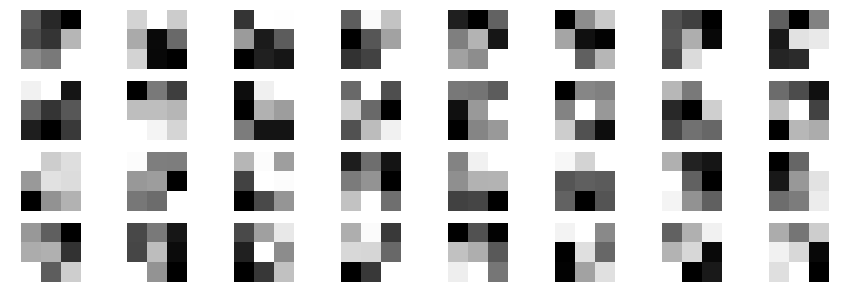

In [43]:
display_width = 8
display_height = 4

fig, axes1 = plt.subplots(display_height,display_width,figsize=(15,5))
counter = 0
for j in range(display_height):
    for k in range(display_width):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(weights[0][:,:,0,counter], cmap="binary")
        counter += 1

Recently however there has been interesting work on trying to figure out what sort of features would activate what
features - i.e. can we see how convnets view the world or better interpret what these features are learning?

See [here](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) and [here](https://distill.pub/2017/feature-visualization/) for a really great discussion with lots of insight (Thanks Paul for the tip)

#### 3) Beyond Convolutional Neural Networks:

It's worth noting that very recently (NIPS 2017) the idea of [capsule networks](https://arxiv.org/abs/1710.09829) has been proposed. These are generalizations of convolutional neural networks, but which are capable of encoding the relative position of local features in a much more sophisticated way!

These look extremely promising, and clean/informative Keras code can be found [here](https://github.com/XifengGuo/CapsNet-Keras) (Although, definitely read the paper first!!)